<a href="https://colab.research.google.com/github/haresh93/ERA-submissions/blob/main/S9/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf .git .config/ ./* sample_data/
!git clone https://github.com/haresh93/ERA-submissions.git .
%cd S9/

Cloning into '.'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (144/144), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 144 (delta 65), reused 73 (delta 28), pack-reused 0
Receiving objects: 100% (144/144), 683.78 KiB | 17.99 MiB/s, done.
Resolving deltas: 100% (65/65), done.
/content/S9


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm
!pip3 install albumentations

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [5]:
# Train and Test Transforms
train_transforms = A.Compose([
        A.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        # A.PadIfNeeded(min_height=40, min_width=40, always_apply=True),
        # A.RandomCrop(height=32, width=32, always_apply=True),
        A.HorizontalFlip(),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes = 1, max_height=16, max_width=16,
                       min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
        ToTensorV2(),
])

test_transforms = A.Compose([
                                      A.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                      ToTensorV2(),
])

In [6]:
from dataset import Cifar10SearchDataset
# Train and Test Datasets
train_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=True, download=True,
                    transform=train_transforms)
test_dataset = Cifar10SearchDataset('~/data/CIFAR10', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 99750100.70it/s] 


Extracting /root/data/CIFAR10/cifar-10-python.tar.gz to /root/data/CIFAR10
Files already downloaded and verified


In [7]:
dataloader_args = dict(shuffle = True, batch_size = 512, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
from model import model_summary, Net

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             288
            Conv2d-6          [-1, 128, 32, 32]           4,096
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 16, 16]          73,728
           Conv2d-11           [-1, 64, 16, 16]             576
           Conv2d-12          [-1, 128, 16, 16]           8,192
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

In [9]:
from model import Net, model_train, model_test, draw_graphs, plot_misclassified_images
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay = 0.0001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, epoch)
    scheduler.step()
    model_test(model, device, test_dataloader)

EPOCH: 0


Train: Loss=1.5384 Batch_id=97 Accuracy=36.66: 100%|██████████| 98/98 [00:12<00:00,  7.98it/s]



Test set: Average loss: 1.4639, Accuracy: 4578/10000 (45.78%)

EPOCH: 1


Train: Loss=1.3060 Batch_id=97 Accuracy=48.04: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]



Test set: Average loss: 1.1744, Accuracy: 5689/10000 (56.89%)

EPOCH: 2


Train: Loss=1.3162 Batch_id=97 Accuracy=54.31: 100%|██████████| 98/98 [00:11<00:00,  8.57it/s]



Test set: Average loss: 1.1410, Accuracy: 6021/10000 (60.21%)

EPOCH: 3


Train: Loss=1.1808 Batch_id=97 Accuracy=57.64: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]



Test set: Average loss: 1.0602, Accuracy: 6168/10000 (61.68%)

EPOCH: 4


Train: Loss=1.1033 Batch_id=97 Accuracy=60.16: 100%|██████████| 98/98 [00:11<00:00,  8.43it/s]



Test set: Average loss: 0.9193, Accuracy: 6756/10000 (67.56%)

EPOCH: 5


Train: Loss=1.0140 Batch_id=97 Accuracy=61.68: 100%|██████████| 98/98 [00:11<00:00,  8.41it/s]



Test set: Average loss: 0.9256, Accuracy: 6708/10000 (67.08%)

EPOCH: 6


Train: Loss=0.9440 Batch_id=97 Accuracy=63.72: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]



Test set: Average loss: 0.7782, Accuracy: 7289/10000 (72.89%)

EPOCH: 7


Train: Loss=1.1276 Batch_id=97 Accuracy=64.87: 100%|██████████| 98/98 [00:11<00:00,  8.28it/s]



Test set: Average loss: 0.8031, Accuracy: 7232/10000 (72.32%)

EPOCH: 8


Train: Loss=1.0157 Batch_id=97 Accuracy=65.94: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]



Test set: Average loss: 0.8010, Accuracy: 7206/10000 (72.06%)

EPOCH: 9


Train: Loss=0.9332 Batch_id=97 Accuracy=66.38: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]



Test set: Average loss: 0.7163, Accuracy: 7530/10000 (75.30%)

EPOCH: 10


Train: Loss=1.0468 Batch_id=97 Accuracy=67.29: 100%|██████████| 98/98 [00:11<00:00,  8.22it/s]



Test set: Average loss: 0.7541, Accuracy: 7395/10000 (73.95%)

EPOCH: 11


Train: Loss=0.8717 Batch_id=97 Accuracy=68.17: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Test set: Average loss: 0.7247, Accuracy: 7403/10000 (74.03%)

EPOCH: 12


Train: Loss=0.8226 Batch_id=97 Accuracy=68.93: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]



Test set: Average loss: 0.7379, Accuracy: 7470/10000 (74.70%)

EPOCH: 13


Train: Loss=0.8901 Batch_id=97 Accuracy=68.80: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]



Test set: Average loss: 0.7240, Accuracy: 7549/10000 (75.49%)

EPOCH: 14


Train: Loss=0.8069 Batch_id=97 Accuracy=69.60: 100%|██████████| 98/98 [00:12<00:00,  8.10it/s]



Test set: Average loss: 0.6476, Accuracy: 7799/10000 (77.99%)

EPOCH: 15


Train: Loss=0.6696 Batch_id=97 Accuracy=73.09: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Test set: Average loss: 0.5167, Accuracy: 8226/10000 (82.26%)

EPOCH: 16


Train: Loss=0.7134 Batch_id=97 Accuracy=74.82: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Test set: Average loss: 0.5009, Accuracy: 8297/10000 (82.97%)

EPOCH: 17


Train: Loss=0.6653 Batch_id=97 Accuracy=75.52: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]



Test set: Average loss: 0.4938, Accuracy: 8293/10000 (82.93%)

EPOCH: 18


Train: Loss=0.6956 Batch_id=97 Accuracy=76.06: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]



Test set: Average loss: 0.4784, Accuracy: 8346/10000 (83.46%)

EPOCH: 19


Train: Loss=0.7088 Batch_id=97 Accuracy=76.10: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Test set: Average loss: 0.4720, Accuracy: 8399/10000 (83.99%)

EPOCH: 20


Train: Loss=0.7535 Batch_id=97 Accuracy=76.34: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]



Test set: Average loss: 0.4676, Accuracy: 8417/10000 (84.17%)

EPOCH: 21


Train: Loss=0.6115 Batch_id=97 Accuracy=77.03: 100%|██████████| 98/98 [00:12<00:00,  8.16it/s]



Test set: Average loss: 0.4677, Accuracy: 8395/10000 (83.95%)

EPOCH: 22


Train: Loss=0.7191 Batch_id=97 Accuracy=76.90: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Test set: Average loss: 0.4561, Accuracy: 8415/10000 (84.15%)

EPOCH: 23


Train: Loss=0.6599 Batch_id=97 Accuracy=77.23: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]



Test set: Average loss: 0.4542, Accuracy: 8436/10000 (84.36%)

EPOCH: 24


Train: Loss=0.6629 Batch_id=97 Accuracy=77.40: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]



Test set: Average loss: 0.4491, Accuracy: 8465/10000 (84.65%)

EPOCH: 25


Train: Loss=0.6128 Batch_id=97 Accuracy=77.72: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Test set: Average loss: 0.4454, Accuracy: 8474/10000 (84.74%)

EPOCH: 26


Train: Loss=0.7412 Batch_id=97 Accuracy=77.52: 100%|██████████| 98/98 [00:12<00:00,  8.09it/s]



Test set: Average loss: 0.4360, Accuracy: 8512/10000 (85.12%)

EPOCH: 27


Train: Loss=0.7463 Batch_id=97 Accuracy=77.77: 100%|██████████| 98/98 [00:12<00:00,  7.86it/s]



Test set: Average loss: 0.4459, Accuracy: 8457/10000 (84.57%)

EPOCH: 28


Train: Loss=0.6680 Batch_id=97 Accuracy=78.32: 100%|██████████| 98/98 [00:13<00:00,  7.41it/s]



Test set: Average loss: 0.4376, Accuracy: 8525/10000 (85.25%)

EPOCH: 29


Train: Loss=0.6403 Batch_id=97 Accuracy=78.44: 100%|██████████| 98/98 [00:12<00:00,  8.13it/s]



Test set: Average loss: 0.4419, Accuracy: 8505/10000 (85.05%)

EPOCH: 30


Train: Loss=0.5438 Batch_id=97 Accuracy=78.60: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Test set: Average loss: 0.4263, Accuracy: 8533/10000 (85.33%)

EPOCH: 31


Train: Loss=0.5706 Batch_id=97 Accuracy=79.03: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]



Test set: Average loss: 0.4214, Accuracy: 8561/10000 (85.61%)

EPOCH: 32


Train: Loss=0.5409 Batch_id=97 Accuracy=79.18: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s]



Test set: Average loss: 0.4203, Accuracy: 8554/10000 (85.54%)

EPOCH: 33


Train: Loss=0.6226 Batch_id=97 Accuracy=79.13: 100%|██████████| 98/98 [00:12<00:00,  8.08it/s]



Test set: Average loss: 0.4202, Accuracy: 8567/10000 (85.67%)

EPOCH: 34


Train: Loss=0.5677 Batch_id=97 Accuracy=79.33: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s]



Test set: Average loss: 0.4185, Accuracy: 8572/10000 (85.72%)

EPOCH: 35


Train: Loss=0.6074 Batch_id=97 Accuracy=79.06: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]



Test set: Average loss: 0.4194, Accuracy: 8574/10000 (85.74%)

EPOCH: 36


Train: Loss=0.5650 Batch_id=97 Accuracy=79.38: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]



Test set: Average loss: 0.4163, Accuracy: 8577/10000 (85.77%)

EPOCH: 37


Train: Loss=0.5867 Batch_id=97 Accuracy=79.69: 100%|██████████| 98/98 [00:12<00:00,  8.07it/s]



Test set: Average loss: 0.4161, Accuracy: 8577/10000 (85.77%)

EPOCH: 38


Train: Loss=0.4804 Batch_id=97 Accuracy=79.40: 100%|██████████| 98/98 [00:12<00:00,  8.07it/s]



Test set: Average loss: 0.4145, Accuracy: 8584/10000 (85.84%)

EPOCH: 39


Train: Loss=0.5614 Batch_id=97 Accuracy=79.36: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Test set: Average loss: 0.4128, Accuracy: 8595/10000 (85.95%)

EPOCH: 40


Train: Loss=0.6748 Batch_id=97 Accuracy=79.41: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]



Test set: Average loss: 0.4126, Accuracy: 8600/10000 (86.00%)

EPOCH: 41


Train: Loss=0.5733 Batch_id=97 Accuracy=79.57: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Test set: Average loss: 0.4130, Accuracy: 8590/10000 (85.90%)

EPOCH: 42


Train: Loss=0.5814 Batch_id=97 Accuracy=79.76: 100%|██████████| 98/98 [00:11<00:00,  8.21it/s]



Test set: Average loss: 0.4114, Accuracy: 8598/10000 (85.98%)

EPOCH: 43


Train: Loss=0.5825 Batch_id=97 Accuracy=79.64: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s]



Test set: Average loss: 0.4113, Accuracy: 8600/10000 (86.00%)

EPOCH: 44


Train: Loss=0.5484 Batch_id=97 Accuracy=79.48: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s]



Test set: Average loss: 0.4109, Accuracy: 8606/10000 (86.06%)

EPOCH: 45


Train: Loss=0.6300 Batch_id=97 Accuracy=79.80: 100%|██████████| 98/98 [00:12<00:00,  8.14it/s]



Test set: Average loss: 0.4107, Accuracy: 8598/10000 (85.98%)

EPOCH: 46


Train: Loss=0.6078 Batch_id=97 Accuracy=79.77: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Test set: Average loss: 0.4102, Accuracy: 8601/10000 (86.01%)

EPOCH: 47


Train: Loss=0.5394 Batch_id=97 Accuracy=79.55: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s]



Test set: Average loss: 0.4099, Accuracy: 8593/10000 (85.93%)

EPOCH: 48


Train: Loss=0.6205 Batch_id=97 Accuracy=79.77: 100%|██████████| 98/98 [00:11<00:00,  8.19it/s]



Test set: Average loss: 0.4099, Accuracy: 8610/10000 (86.10%)

EPOCH: 49


Train: Loss=0.5115 Batch_id=97 Accuracy=79.87: 100%|██████████| 98/98 [00:12<00:00,  8.05it/s]



Test set: Average loss: 0.4103, Accuracy: 8610/10000 (86.10%)



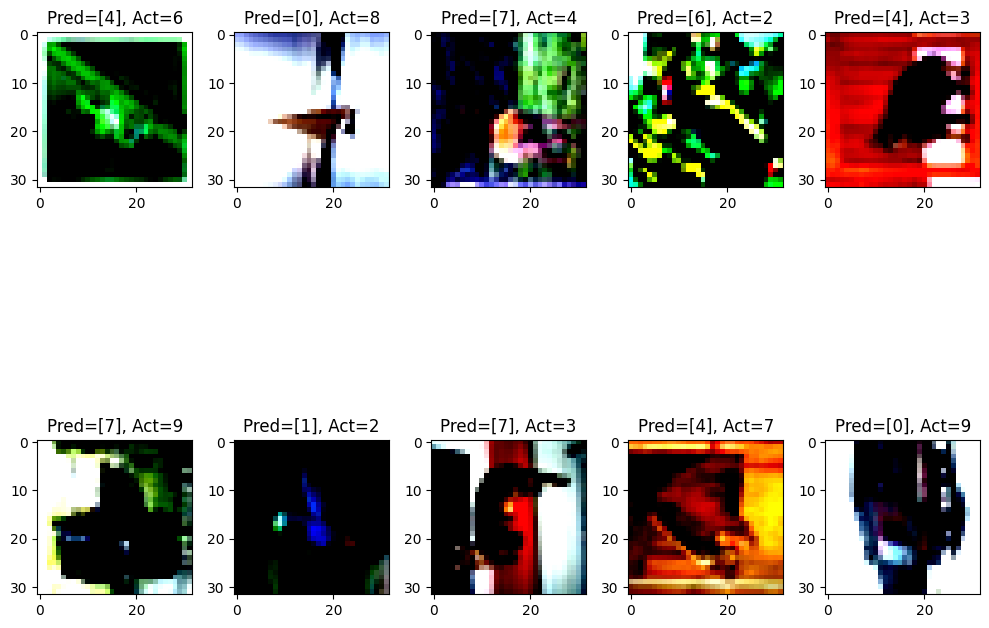

In [10]:
plot_misclassified_images()

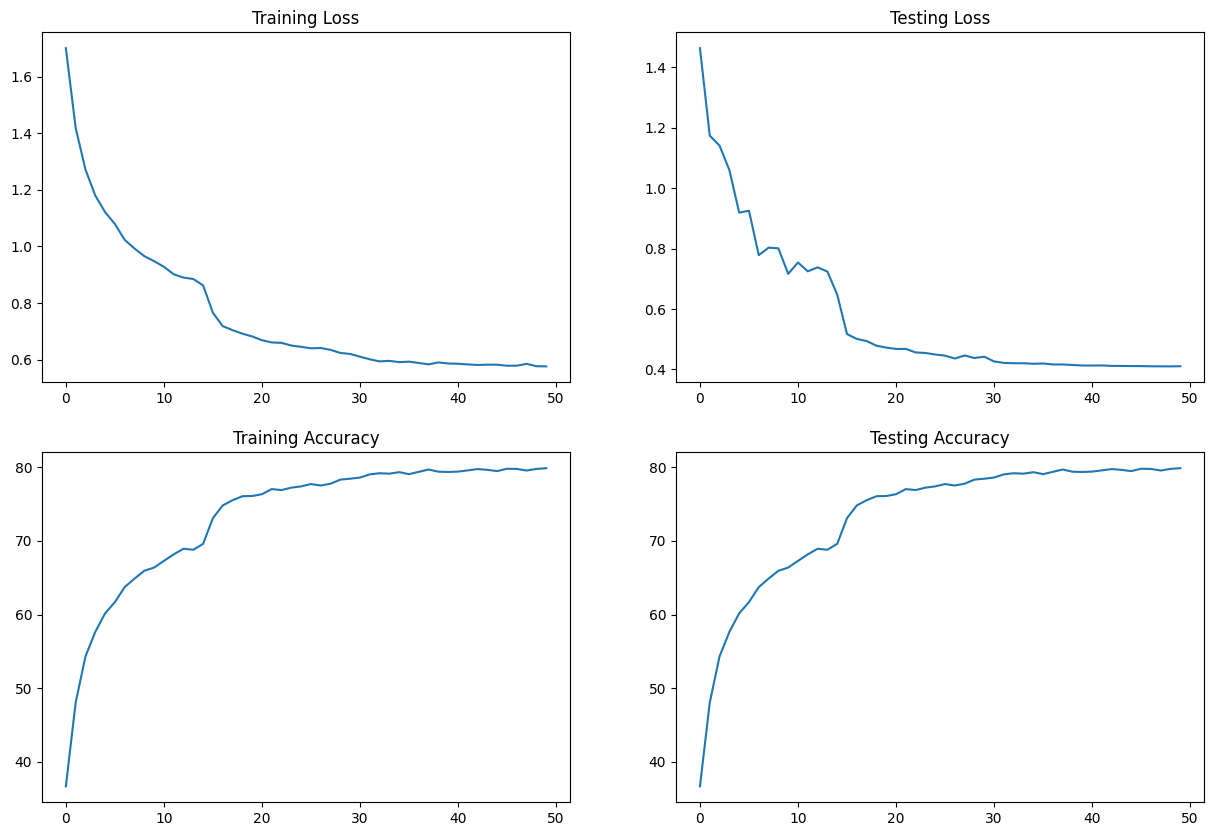

In [11]:
draw_graphs()